In [2]:
import scanpy as sc
import pandas as pd

# === Load AnnData object ===
adata = sc.read_h5ad("neuron_atlas.h5ad")

# === Print dataset dimensions ===
print(f"adata shape: {adata.shape} (cells x genes)\n")

# === View observation (cell-level) metadata ===
print("Available `obs` columns (cell metadata):")
print(adata.obs.columns.tolist(), "\n")

# === View variable (gene-level) metadata ===
print("Available `var` columns (gene metadata):")
print(adata.var.columns.tolist(), "\n")



# Optional: print unique perturbations or cell types
if "perturbation" in adata.obs:
    print("\nUnique perturbations:")
    print(adata.obs["perturbation"].unique())

if "cell_type" in adata.obs:
    print("\nUnique cell types:")
    print(adata.obs["cell_type"].unique())


adata shape: (156726, 33159) (cells x genes)

Available `obs` columns (cell metadata):
['Age', 'ClassAnn', 'Souporcell', 'Subclass', 'Superclass', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'total_genes', 'total_UMIs', 'sample_id', 'CellType', 'cluster_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'] 

Available `var` columns (gene metadata):
['Chromosome', 'End', 'Gene', 'Start', 'Strand', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'] 


Unique cell types:
['oligodendrocyte precursor cell', 'interneuron', 'neuron', 'forebrain radial glial cell', 'fo

In [3]:
import scanpy as sc

# === Load original dataset ===
adata = sc.read_h5ad("neuron_atlas.h5ad")

# === Subset to only "neuron" cells ===
neuron_mask = adata.obs["cell_type"] == "neuron"
adata_neuron = adata[neuron_mask].copy()

# === Save to new file ===
adata_neuron.write("neuron_only.h5ad")

print(f"Saved neuron-only data with shape: {adata_neuron.shape}")


Saved neuron-only data with shape: (589, 33159)


In [4]:
adata_neuron.X

<589x33159 sparse matrix of type '<class 'numpy.float32'>'
	with 1267129 stored elements in Compressed Sparse Row format>

In [15]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from scipy.sparse import issparse
from scipy.stats import ttest_ind
from scipy.linalg import pinv
import matplotlib.pyplot as plt
import pickle
import pymc as pm

def compute_sparsity(X, label=''):
    total = np.prod(X.shape)
    zeros = np.sum(X == 0)
    sparsity = zeros / total if total > 0 else float('nan')
    print(f"{label} sparsity: {sparsity:.2%} ({zeros} of {total} zeros)")
    return sparsity

def extract_X(adata, pert_name):
    """Extracts expression matrix for a given perturbation name."""
    return adata[adata.obs["perturbation"] == pert_name].X.toarray() if issparse(adata.X) else adata[adata.obs["perturbation"] == pert_name].X

def get_tian_and_neuronatlas_matched_data(tian_path, neuron_atlas_path, expression_threshold=1.0, min_samples=100):
    # === Load datasets ===
    adata_tian = ad.read_h5ad(tian_path)
    adata_atlas = ad.read_h5ad(neuron_atlas_path)

    # === Harmonize gene names ===
    if "gene_symbol" in adata_tian.var.columns:
        adata_tian.var_names = adata_tian.var["gene_symbol"]
    if "Gene" in adata_atlas.var.columns:
        adata_atlas.var_names = adata_atlas.var["Gene"]

    # Convert to string and strip whitespace
    adata_tian.var_names = adata_tian.var_names.astype(str).str.strip()
    adata_atlas.var_names = adata_atlas.var_names.astype(str).str.strip()

    # Ensure unique gene names to avoid indexing issues
    adata_tian.var_names_make_unique()
    adata_atlas.var_names_make_unique()

    # === Debug: gene name overlap ===
    print("Tian gene names example:", adata_tian.var_names[:5].tolist())
    print("Atlas gene names example:", adata_atlas.var_names[:5].tolist())
    print("Raw intersection count:", len(set(adata_tian.var_names) & set(adata_atlas.var_names)))

    # === Preprocess Tian: filter by perturbation count ===
    adata_tian.obs['perturbation_base'] = adata_tian.obs['perturbation'].str.replace(r'_g\d+$', '', regex=True)
    pert_counts = adata_tian.obs['perturbation'].value_counts()
    valid_perts = pert_counts[pert_counts >= min_samples].index.tolist()
    adata_tian = adata_tian[adata_tian.obs['perturbation'].isin(valid_perts)].copy()

    # === Expression filtering: Tian ===
    gene_means_tian = adata_tian.X.mean(axis=0).A1 if issparse(adata_tian.X) else adata_tian.X.mean(axis=0)
    expressed_genes_tian = set(adata_tian.var_names[np.where(gene_means_tian >= expression_threshold)[0]])
    target_genes = set(adata_tian.obs['perturbation_base'].unique())
    genes_to_keep_tian = expressed_genes_tian | (target_genes & set(adata_tian.var_names))

    # === Expression filtering: Atlas ===
    gene_means_atlas = adata_atlas.X.mean(axis=0).A1 if issparse(adata_atlas.X) else adata_atlas.X.mean(axis=0)
    expressed_genes_atlas = set(adata_atlas.var_names[np.where(gene_means_atlas >= expression_threshold)[0]])

    # === Gene set intersection ===
    shared_genes = list((genes_to_keep_tian | expressed_genes_atlas) & 
                        set(adata_tian.var_names) & set(adata_atlas.var_names))
    
    adata_tian = adata_tian[:, shared_genes].copy()
    adata_atlas = adata_atlas[:, shared_genes].copy()

    print(f"\nMatched {len(shared_genes)} genes across Tian and Atlas datasets.")
    print(f"{adata_tian.obs['perturbation'].nunique()} Tian perturbations after filtering")
    print(f"{adata_atlas.shape[0]} neuron atlas cells used as perturbed X1")

    # === Extract X0 (control) and X1 (neurons) ===
    X0 = extract_X(adata_tian, 'control')
    X1 = adata_atlas.X.toarray() if issparse(adata_atlas.X) else adata_atlas.X

    compute_sparsity(X0, label='X0 (Tian control)')
    compute_sparsity(X1, label='X1 (NeuronAtlas neurons)')

    return adata_tian, adata_atlas, X0, X1

# === Run function ===
adata_tian, adata_neuronatlas, X0, X1 = get_tian_and_neuronatlas_matched_data(
    "TianKampmann2019_day7neuron.h5ad",
    "neuron_only.h5ad",
    expression_threshold=0.1  # safer default for debugging
)


/Users/bdk6456/miniconda3/envs/pymc_env/lib/python3.11/site-packages/anndata/_core/anndata.py:835: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['NKX2-2', 'OLIG1', 'LRRC4C', 'AC092747.1', 'OLIG2']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


Tian gene names example: ['RP11-34P13.3', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8']
Atlas gene names example: ['NKX2-2', 'OLIG1', 'LRRC4C', 'AC092747.1', 'OLIG2']
Raw intersection count: 22075

Matched 7438 genes across Tian and Atlas datasets.
104 Tian perturbations after filtering
589 neuron atlas cells used as perturbed X1
X0 (Tian control) sparsity: 97.39% (112861198 of 115884040 zeros)
X1 (NeuronAtlas neurons) sparsity: 75.71% (3316837 of 4380982 zeros)



--- Processing TianKampmann2019_day7neuron.h5ad ---


/Users/bdk6456/miniconda3/envs/pymc_env/lib/python3.11/site-packages/anndata/_core/anndata.py:835: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['NKX2-2', 'OLIG1', 'LRRC4C', 'AC092747.1', 'OLIG2']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


Tian gene names example: ['RP11-34P13.3', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8']
Atlas gene names example: ['NKX2-2', 'OLIG1', 'LRRC4C', 'AC092747.1', 'OLIG2']
Raw intersection count: 22075

Matched 7438 genes across Tian and Atlas datasets.
104 Tian perturbations after filtering
589 neuron atlas cells used as perturbed X1
X0 (Tian control) sparsity: 97.39% (112861198 of 115884040 zeros)
X1 (NeuronAtlas neurons) sparsity: 75.71% (3316837 of 4380982 zeros)
Average R² (Tian):  0.680
Average R² (Atlas): 0.385

--- Processing TianKampmann2019_iPSC.h5ad ---


/Users/bdk6456/miniconda3/envs/pymc_env/lib/python3.11/site-packages/anndata/_core/anndata.py:835: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['NKX2-2', 'OLIG1', 'LRRC4C', 'AC092747.1', 'OLIG2']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


Tian gene names example: ['RP11-34P13.3', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8']
Atlas gene names example: ['NKX2-2', 'OLIG1', 'LRRC4C', 'AC092747.1', 'OLIG2']
Raw intersection count: 22075

Matched 7395 genes across Tian and Atlas datasets.
154 Tian perturbations after filtering
589 neuron atlas cells used as perturbed X1
X0 (Tian control) sparsity: 98.79% (78076042 of 79030365 zeros)
X1 (NeuronAtlas neurons) sparsity: 75.59% (3292412 of 4355655 zeros)
Average R² (Tian):  0.559
Average R² (Atlas): 0.152

--- Processing TianKampmann2021_CRISPRa.h5ad ---


/Users/bdk6456/miniconda3/envs/pymc_env/lib/python3.11/site-packages/anndata/_core/anndata.py:835: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['NKX2-2', 'OLIG1', 'LRRC4C', 'AC092747.1', 'OLIG2']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


Tian gene names example: ['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3']
Atlas gene names example: ['NKX2-2', 'OLIG1', 'LRRC4C', 'AC092747.1', 'OLIG2']
Raw intersection count: 33159

Matched 10163 genes across Tian and Atlas datasets.
95 Tian perturbations after filtering
589 neuron atlas cells used as perturbed X1
X0 (Tian control) sparsity: 65.78% (2901417 of 4410742 zeros)
X1 (NeuronAtlas neurons) sparsity: 80.40% (4813009 of 5986007 zeros)
Average R² (Tian):  0.417
Average R² (Atlas): 0.262

==== Summary Across All Datasets ====
Overall R²(Tian vs Atlas): 0.036
Global Mean R² (Tian):     0.487
Global Mean R² (Atlas):    0.264


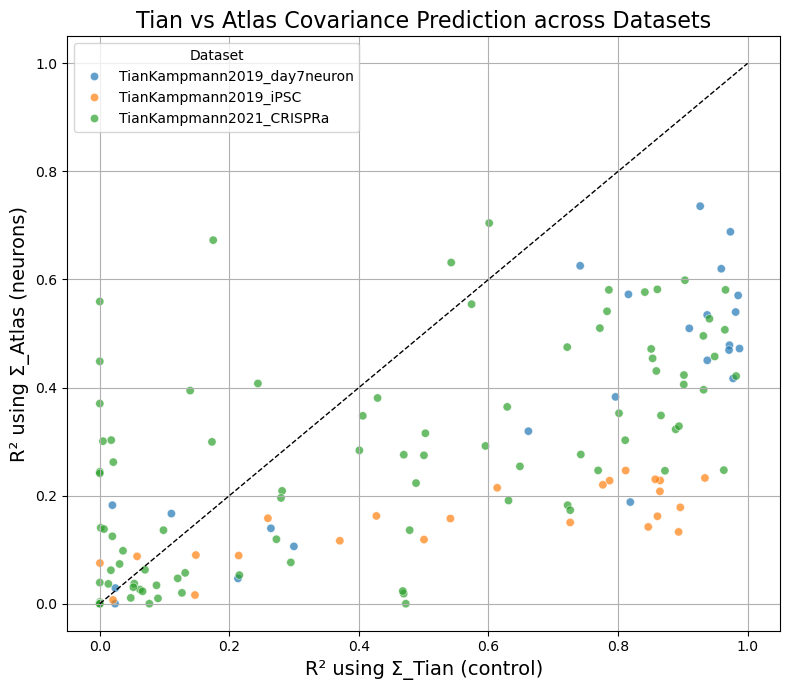

In [21]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse
from sklearn.metrics import r2_score

# === Tian datasets and neuron atlas ===
tian_paths = [
    "TianKampmann2019_day7neuron.h5ad",
    "TianKampmann2019_iPSC.h5ad",
    "TianKampmann2021_CRISPRa.h5ad"
]
neuron_atlas_path = "neuron_only.h5ad"

all_r2_dfs = []

for path in tian_paths:
    print(f"\n--- Processing {path} ---")
    try:
        adata_tian, adata_atlas, X0, X1 = get_tian_and_neuronatlas_matched_data(
            path,
            neuron_atlas_path,
            expression_threshold=0.1,
            min_samples=100
        )

        # Compute covariances
        Sigma_tian = np.cov(X0 - X0.mean(axis=0), rowvar=False)
        Sigma_atlas = np.cov(X1 - X1.mean(axis=0), rowvar=False)
        gene_names = np.array(adata_tian.var_names)

        def get_deltaX(adata, pert):
            X0 = adata[adata.obs['perturbation'] == 'control'].X
            X1 = adata[adata.obs['perturbation'] == pert].X
            X0 = X0.toarray() if issparse(X0) else X0
            X1 = X1.toarray() if issparse(X1) else X1
            return X1.mean(axis=0) - X0.mean(axis=0)

        def predict_r2_from_cov_column(deltaX, Sigma, gene_idx, epsilon=1e-8):
            v = Sigma[:, gene_idx]
            alpha = np.dot(v, deltaX) / (np.dot(v, v) + epsilon)
            deltaX_pred = alpha * v
            valid = np.abs(deltaX) > 0
            if not np.any(valid): return np.nan
            return 1.0 - np.sum((deltaX[valid] - deltaX_pred[valid])**2) / (np.sum(deltaX[valid]**2) + epsilon)

        perturbations = [p for p in adata_tian.obs["perturbation"].unique() if p != "control"]
        r2_tian, r2_atlas, pert_list = [], [], []

        for pert in perturbations:
            base_gene = re.sub(r"_g\d+$", "", pert)
            if base_gene not in gene_names:
                continue
            gene_idx = np.where(gene_names == base_gene)[0][0]
            deltaX = get_deltaX(adata_tian, pert)

            r2_real = predict_r2_from_cov_column(deltaX, Sigma_tian, gene_idx)
            r2_alt = predict_r2_from_cov_column(deltaX, Sigma_atlas, gene_idx)

            r2_tian.append(r2_real)
            r2_atlas.append(r2_alt)
            pert_list.append(pert)

        df = pd.DataFrame({
            "perturbation": pert_list,
            "R2_tian": r2_tian,
            "R2_atlas": r2_atlas,
            "dataset": os.path.basename(path).replace(".h5ad", "")
        })

        print(f"Average R² (Tian):  {np.nanmean(r2_tian):.3f}")
        print(f"Average R² (Atlas): {np.nanmean(r2_atlas):.3f}")

        all_r2_dfs.append(df)

    except Exception as e:
        print(f"❌ Error processing {path}: {e}")

# === Combine and summarize ===
df_all = pd.concat(all_r2_dfs, ignore_index=True)

# Meta R² across all datasets
valid = df_all[["R2_tian", "R2_atlas"]].dropna()
meta_r2 = r2_score(valid["R2_tian"], valid["R2_atlas"])
print(f"\n==== Summary Across All Datasets ====")
print(f"Overall R²(Tian vs Atlas): {meta_r2:.3f}")
print(f"Global Mean R² (Tian):     {valid['R2_tian'].mean():.3f}")
print(f"Global Mean R² (Atlas):    {valid['R2_atlas'].mean():.3f}")

# === Plot ===
plt.figure(figsize=(8, 7))
sns.scatterplot(data=df_all, x="R2_tian", y="R2_atlas", hue="dataset", alpha=0.7)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel("R² using Σ_Tian (control)", fontsize=14)
plt.ylabel("R² using Σ_Atlas (neurons)", fontsize=14)
plt.title("Tian vs Atlas Covariance Prediction across Datasets", fontsize=16)
plt.grid(True)
plt.legend(title="Dataset", fontsize=10)
plt.tight_layout()
plt.savefig("r2_tian_vs_atlas_all.svg")
plt.show()

# === Compute overall R² across all perturbations ===
valid = df_all[["R2_tian", "R2_atlas"]].dropna()
meta_r2 = r2_score(valid["R2_tian"], valid["R2_atlas"])

# === Plot with inline meta R² annotation ===
plt.figure(figsize=(8, 7))
sns.scatterplot(data=df_all, x="R2_tian", y="R2_atlas", hue="dataset", alpha=0.7)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel("R² (true Σ)", fontsize=14)
plt.ylabel("R² (cross Σ)", fontsize=14)
plt.title("R² comparison across neuron datasets", fontsize=16)
plt.grid(True)
plt.legend(title="Dataset", fontsize=10)

# === Add inline R² annotation ===
plt.text(0.05, 0.96, f"✅ Overall R² (cross Σ vs true Σ across all comparisons): {meta_r2:.4f}",
         fontsize=11, transform=plt.gca().transAxes, ha='left', va='top')

plt.tight_layout()
plt.savefig("r2_tian_vs_atlas_all.svg")
plt.show()




==== Summary Across All Datasets ====
✅ Custom R² (1 - |Δ|² / |R2_tian|²): 0.6498
Global Mean R² (Tian):  0.487
Global Mean R² (Atlas): 0.264


/var/folders/tc/qjb0w1k122v4jzwncjlh51140000gp/T/ipykernel_65091/2208502808.py:34: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/tc/qjb0w1k122v4jzwncjlh51140000gp/T/ipykernel_65091/2208502808.py:35: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig("r2_tian_vs_atlas_all.svg")
/Users/bdk6456/miniconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


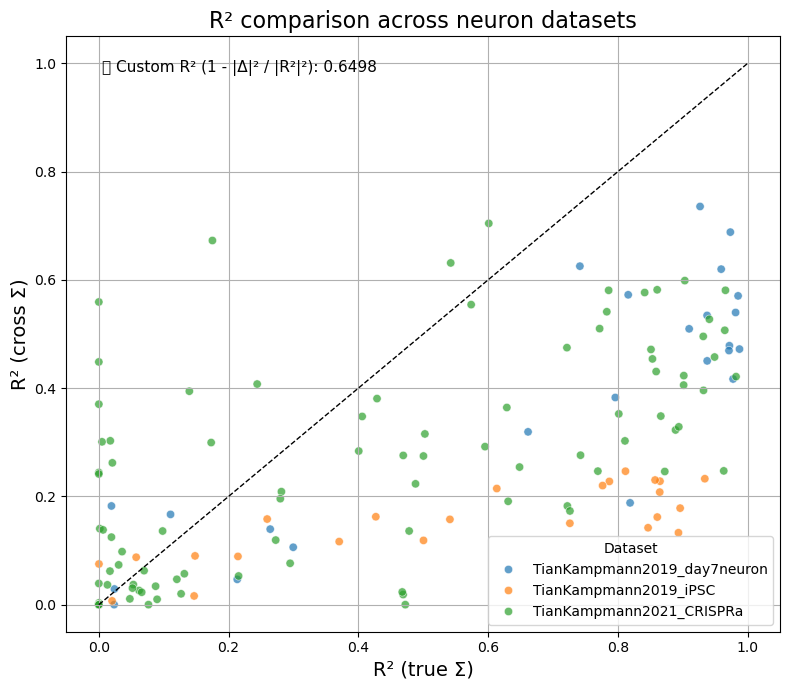

In [23]:
# === Combine all results ===
df_all = pd.concat(all_r2_dfs, ignore_index=True)

# === Filter valid points ===
valid = df_all[["R2_tian", "R2_atlas"]].dropna()
r2_tian = valid["R2_tian"].values
r2_atlas = valid["R2_atlas"].values

# === Compute your custom geometric R²: 1 - |Δ|² / |x|² ===
numerator = np.sum((r2_tian - r2_atlas) ** 2)
denominator = np.sum(r2_tian ** 2) + 1e-8  # avoid divide-by-zero
custom_r2 = 1.0 - numerator / denominator

# === Print summary ===
print("\n==== Summary Across All Datasets ====")
print(f"✅ Custom R² (1 - |Δ|² / |R2_tian|²): {custom_r2:.4f}")
print(f"Global Mean R² (Tian):  {np.mean(r2_tian):.3f}")
print(f"Global Mean R² (Atlas): {np.mean(r2_atlas):.3f}")

# === Plot with inline annotation ===
plt.figure(figsize=(8, 7))
sns.scatterplot(data=df_all, x="R2_tian", y="R2_atlas", hue="dataset", alpha=0.7)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel("R² (true Σ)", fontsize=14)
plt.ylabel("R² (cross Σ)", fontsize=14)
plt.title("R² comparison across neuron datasets", fontsize=16)
plt.grid(True)
plt.legend(title="Dataset", fontsize=10)

# === Add custom R² annotation ===
plt.text(0.05, 0.96, f"✅ Custom R² (1 - |Δ|² / |R²|²): {custom_r2:.4f}",
         fontsize=11, transform=plt.gca().transAxes, ha='left', va='top')

plt.tight_layout()
plt.savefig("r2_tian_vs_atlas_all.svg")
plt.show()


In [ ]:
# average each dataset separatly 

In [30]:
# === DO NOT RUN ===

import anndata as ad
import numpy as np
import pandas as pd
import os
import re
from scipy.sparse import issparse
from sklearn.metrics import r2_score
from tqdm import tqdm

# === Paths ===
tian_paths = [
    "TianKampmann2019_day7neuron.h5ad",
    "TianKampmann2019_iPSC.h5ad",
    "TianKampmann2021_CRISPRa.h5ad"
]
neuron_atlas_path = "neuron_atlas.h5ad"

# === Load neuron atlas and determine reference size ===
print("📥 Loading neuron atlas...")
adata_atlas_full = ad.read_h5ad(neuron_atlas_path)
celltype_key = "subclass" if "subclass" in adata_atlas_full.obs else "cell_type"
celltype_counts = adata_atlas_full.obs[celltype_key].value_counts()
print(f"✅ Found {len(celltype_counts)} cell types in neuron atlas.")

ref_type = "neuron"
if ref_type not in celltype_counts:
    raise ValueError(f"❌ Reference type '{ref_type}' not found in atlas.")
n_ref_cells = celltype_counts[ref_type]
print(f"📏 Using n = {n_ref_cells} as fixed sample size (from '{ref_type}')")

# === Store results ===
celltype_r2_records = []

# === Helper functions ===
def compute_cov(X): return np.cov(X - X.mean(axis=0), rowvar=False)

def get_deltaX(adata, pert):
    X0 = adata[adata.obs['perturbation'] == 'control'].X
    X1 = adata[adata.obs['perturbation'] == pert].X
    X0 = X0.toarray() if issparse(X0) else X0
    X1 = X1.toarray() if issparse(X1) else X1
    return X1.mean(axis=0) - X0.mean(axis=0)

def predict_r2_from_cov_column(deltaX, Sigma, gene_idx, epsilon=1e-8):
    v = Sigma[:, gene_idx]
    alpha = np.dot(v, deltaX) / (np.dot(v, v) + epsilon)
    deltaX_pred = alpha * v
    valid = np.abs(deltaX) > 0
    if not np.any(valid): return np.nan
    return 1.0 - np.sum((deltaX[valid] - deltaX_pred[valid])**2) / (np.sum(deltaX[valid]**2) + epsilon)

# === Main loop ===
for path in tqdm(tian_paths):
    print(f"\n=== 📊 Processing Tian dataset: {os.path.basename(path)} ===")
    adata_tian = ad.read_h5ad(path)

    # Harmonize gene names
    if "gene_symbol" in adata_tian.var.columns:
        adata_tian.var_names = adata_tian.var["gene_symbol"]
    if "Gene" in adata_atlas_full.var.columns:
        adata_atlas_full.var_names = adata_atlas_full.var["Gene"]
    adata_tian.var_names = adata_tian.var_names.astype(str).str.strip()
    adata_atlas_full.var_names = adata_atlas_full.var_names.astype(str).str.strip()
    adata_tian.var_names_make_unique()
    adata_atlas_full.var_names_make_unique()

    # Filter by perturbation count
    adata_tian.obs['perturbation_base'] = adata_tian.obs['perturbation'].str.replace(r'_g\d+$', '', regex=True)
    valid_perts = adata_tian.obs['perturbation'].value_counts()
    valid_perts = valid_perts[valid_perts >= 100].index.tolist()
    adata_tian = adata_tian[adata_tian.obs['perturbation'].isin(valid_perts)].copy()

    # Expression filtering — Tian
    tian_expr = adata_tian.X.toarray() if issparse(adata_tian.X) else adata_tian.X
    gene_means_tian = tian_expr.mean(axis=0)
    expressed_genes_tian = set(adata_tian.var_names[gene_means_tian > 0.1])
    target_genes = set(adata_tian.obs['perturbation_base'].unique())
    keep_genes_tian = expressed_genes_tian | (target_genes & set(adata_tian.var_names))

    # Expression filtering — Atlas
    atlas_expr = adata_atlas_full.X.toarray() if issparse(adata_atlas_full.X) else adata_atlas_full.X
    gene_means_atlas = atlas_expr.mean(axis=0)
    expressed_genes_atlas = set(adata_atlas_full.var_names[gene_means_atlas > 0.1])

    # Intersect filtered gene sets
    shared_genes = list((keep_genes_tian | expressed_genes_atlas) & set(adata_tian.var_names) & set(adata_atlas_full.var_names))
    if len(shared_genes) < 100:
        print(f"❌ Skipping {path}: too few shared genes after harmonization ({len(shared_genes)})")
        continue

    adata_tian = adata_tian[:, shared_genes].copy()
    adata_atlas_full = adata_atlas_full[:, shared_genes].copy()
    gene_names = np.array(adata_tian.var_names)

    # Compute Tian control covariance
    X0 = adata_tian[adata_tian.obs['perturbation'] == 'control'].X
    X0 = X0.toarray() if issparse(X0) else X0
    Sigma_tian = compute_cov(X0)

    for celltype, count in celltype_counts.items():
        if count < n_ref_cells:
            continue

        print(f"🔁 Comparing with atlas cell type: {celltype} (n={count})")
        atlas_subset = adata_atlas_full[adata_atlas_full.obs[celltype_key] == celltype].copy()
        atlas_subset = atlas_subset[np.random.choice(atlas_subset.shape[0], n_ref_cells, replace=False)]
        X1 = atlas_subset.X.toarray() if issparse(atlas_subset.X) else atlas_subset.X
        Sigma_atlas = compute_cov(X1)

        r2_tian_vals, r2_atlas_vals = [], []
        for pert in adata_tian.obs['perturbation'].unique():
            if pert == "control":
                continue
            base_gene = re.sub(r"_g\d+$", "", pert)
            if base_gene not in gene_names:
                continue
            gene_idx = np.where(gene_names == base_gene)[0][0]
            deltaX = get_deltaX(adata_tian, pert)
            r2_tian_vals.append(predict_r2_from_cov_column(deltaX, Sigma_tian, gene_idx))
            r2_atlas_vals.append(predict_r2_from_cov_column(deltaX, Sigma_atlas, gene_idx))

        if r2_atlas_vals:
            r2_tian_vals = np.array(r2_tian_vals)
            r2_atlas_vals = np.array(r2_atlas_vals)
            custom_r2 = 1.0 - np.nansum((r2_tian_vals - r2_atlas_vals) ** 2) / (np.nansum(r2_tian_vals ** 2) + 1e-8)

            print(f"📈 Mean R² (Tian):  {np.nanmean(r2_tian_vals):.3f}")
            print(f"📉 Mean R² (Atlas): {np.nanmean(r2_atlas_vals):.3f}")
            print(f"🧮 Custom R² (comparison): {custom_r2:.4f}")

            celltype_r2_records.append({
                "dataset": os.path.basename(path).replace(".h5ad", ""),
                "celltype": celltype,
                "mean_R2_tian": np.nanmean(r2_tian_vals),
                "mean_R2_atlas": np.nanmean(r2_atlas_vals),
                "custom_R2": custom_r2
            })

# === Save results ===
r2_summary_df = pd.DataFrame(celltype_r2_records)
r2_summary_df.to_csv("neuron_atlas_celltype_r2_comparisons.csv", index=False)
print("\n✅ Saved summary to neuron_atlas_celltype_r2_comparisons.csv")


📥 Loading neuron atlas...
✅ Found 58 cell types in neuron atlas.
📏 Using n = 589 as fixed sample size (from 'neuron')


  0%|                                                                                        | 0/3 [00:00<?, ?it/s]


=== 📊 Processing Tian dataset: TianKampmann2019_day7neuron.h5ad ===


/Users/bdk6456/miniconda3/envs/pymc_env/lib/python3.11/site-packages/anndata/_core/anndata.py:835: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['NKX2-2', 'OLIG1', 'LRRC4C', 'AC092747.1', 'OLIG2']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


🔁 Comparing with atlas cell type: leptomeningeal cell (n=39277)
📈 Mean R² (Tian):  0.679
📉 Mean R² (Atlas): 0.300
🧮 Custom R² (comparison): 0.6694
🔁 Comparing with atlas cell type: mesenchymal cell (n=17421)
📈 Mean R² (Tian):  0.679
📉 Mean R² (Atlas): 0.387
🧮 Custom R² (comparison): 0.7976
🔁 Comparing with atlas cell type: reticulocyte (n=16262)
📈 Mean R² (Tian):  0.679
📉 Mean R² (Atlas): 0.093
🧮 Custom R² (comparison): 0.2281
🔁 Comparing with atlas cell type: erythroblast (n=14174)
📈 Mean R² (Tian):  0.679
📉 Mean R² (Atlas): 0.017
🧮 Custom R² (comparison): 0.0487
🔁 Comparing with atlas cell type: choroid plexus epithelial cell (n=7903)
📈 Mean R² (Tian):  0.679
📉 Mean R² (Atlas): 0.127
🧮 Custom R² (comparison): 0.3322
🔁 Comparing with atlas cell type: erythroid progenitor cell (n=6203)
📈 Mean R² (Tian):  0.679
📉 Mean R² (Atlas): 0.068
🧮 Custom R² (comparison): 0.1602
🔁 Comparing with atlas cell type: fibroblast of choroid plexus (n=5889)
📈 Mean R² (Tian):  0.679
📉 Mean R² (Atlas): 0.34

 33%|██████████████████████████▎                                                    | 1/3 [02:59<05:59, 179.59s/it]

📈 Mean R² (Tian):  0.679
📉 Mean R² (Atlas): 0.387
🧮 Custom R² (comparison): 0.7839

=== 📊 Processing Tian dataset: TianKampmann2019_iPSC.h5ad ===


/Users/bdk6456/miniconda3/envs/pymc_env/lib/python3.11/site-packages/anndata/_core/anndata.py:835: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ZBTB48', 'LAMTOR4', 'PPP1R12A', 'SUGT1', 'MDH1B']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


🔁 Comparing with atlas cell type: leptomeningeal cell (n=39277)
📈 Mean R² (Tian):  0.556
📉 Mean R² (Atlas): 0.223
🧮 Custom R² (comparison): 0.5452
🔁 Comparing with atlas cell type: mesenchymal cell (n=17421)
📈 Mean R² (Tian):  0.556
📉 Mean R² (Atlas): 0.271
🧮 Custom R² (comparison): 0.6651
🔁 Comparing with atlas cell type: reticulocyte (n=16262)
📈 Mean R² (Tian):  0.556
📉 Mean R² (Atlas): 0.004
🧮 Custom R² (comparison): 0.0140
🔁 Comparing with atlas cell type: erythroblast (n=14174)
📈 Mean R² (Tian):  0.556
📉 Mean R² (Atlas): 0.023
🧮 Custom R² (comparison): 0.0656
🔁 Comparing with atlas cell type: choroid plexus epithelial cell (n=7903)
📈 Mean R² (Tian):  0.556
📉 Mean R² (Atlas): 0.173
🧮 Custom R² (comparison): 0.4357
🔁 Comparing with atlas cell type: erythroid progenitor cell (n=6203)
📈 Mean R² (Tian):  0.556
📉 Mean R² (Atlas): 0.014
🧮 Custom R² (comparison): 0.0423
🔁 Comparing with atlas cell type: fibroblast of choroid plexus (n=5889)
📈 Mean R² (Tian):  0.556
📉 Mean R² (Atlas): 0.23

 67%|████████████████████████████████████████████████████▋                          | 2/3 [05:12<02:32, 152.08s/it]

📈 Mean R² (Tian):  0.556
📉 Mean R² (Atlas): 0.153
🧮 Custom R² (comparison): 0.4304

=== 📊 Processing Tian dataset: TianKampmann2021_CRISPRa.h5ad ===


/Users/bdk6456/miniconda3/envs/pymc_env/lib/python3.11/site-packages/anndata/_core/anndata.py:835: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ZBTB48', 'LAMTOR4', 'PPP1R12A', 'SUGT1', 'MDH1B']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


🔁 Comparing with atlas cell type: leptomeningeal cell (n=39277)
📈 Mean R² (Tian):  0.479
📉 Mean R² (Atlas): 0.311
🧮 Custom R² (comparison): 0.7440
🔁 Comparing with atlas cell type: mesenchymal cell (n=17421)
📈 Mean R² (Tian):  0.479
📉 Mean R² (Atlas): 0.259
🧮 Custom R² (comparison): 0.6110
🔁 Comparing with atlas cell type: reticulocyte (n=16262)
📈 Mean R² (Tian):  0.479
📉 Mean R² (Atlas): 0.030
🧮 Custom R² (comparison): 0.0873
🔁 Comparing with atlas cell type: erythroblast (n=14174)
📈 Mean R² (Tian):  0.479
📉 Mean R² (Atlas): 0.028
🧮 Custom R² (comparison): 0.0923
🔁 Comparing with atlas cell type: choroid plexus epithelial cell (n=7903)
📈 Mean R² (Tian):  0.479
📉 Mean R² (Atlas): 0.157
🧮 Custom R² (comparison): 0.4145
🔁 Comparing with atlas cell type: erythroid progenitor cell (n=6203)
📈 Mean R² (Tian):  0.479
📉 Mean R² (Atlas): 0.086
🧮 Custom R² (comparison): 0.2198
🔁 Comparing with atlas cell type: fibroblast of choroid plexus (n=5889)
📈 Mean R² (Tian):  0.479
📉 Mean R² (Atlas): 0.34

100%|███████████████████████████████████████████████████████████████████████████████| 3/3 [08:36<00:00, 172.09s/it]

📈 Mean R² (Tian):  0.479
📉 Mean R² (Atlas): 0.293
🧮 Custom R² (comparison): 0.7096

✅ Saved summary to neuron_atlas_celltype_r2_comparisons.csv


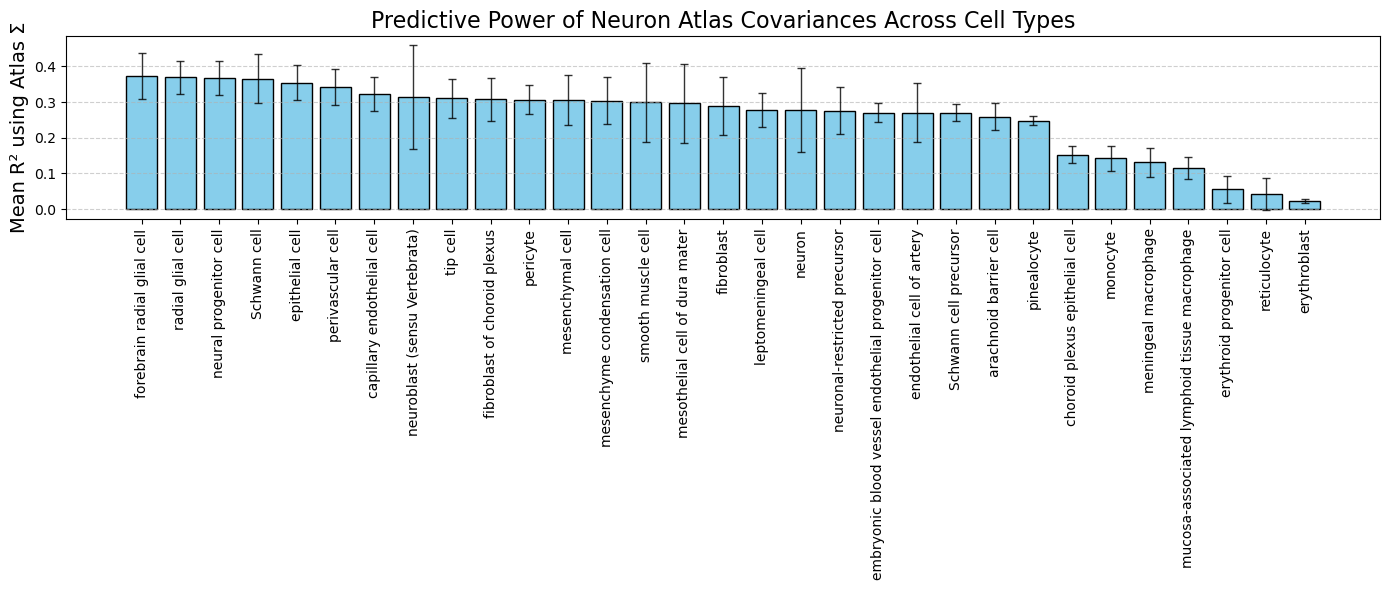

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load the summary if needed ===
# r2_summary_df = pd.read_csv("neuron_atlas_celltype_r2_comparisons.csv")

# === Compute mean and std of R² from atlas Σ per celltype ===
grouped = r2_summary_df.groupby("celltype")["mean_R2_atlas"]
mean_r2 = grouped.mean()
std_r2 = grouped.std()

# === Sort by mean and align std accordingly ===
mean_r2_sorted = mean_r2.sort_values(ascending=False)
std_r2_sorted = std_r2[mean_r2_sorted.index]

# === Plot with error bars ===
plt.figure(figsize=(14, 6))
plt.bar(mean_r2_sorted.index, mean_r2_sorted.values, yerr=std_r2_sorted.values,
        capsize=3, color="skyblue", edgecolor="k", error_kw={"elinewidth": 1, "alpha": 0.8})

plt.ylabel("Mean R² using Atlas Σ", fontsize=14)
plt.title("Predictive Power of Neuron Atlas Covariances Across Cell Types", fontsize=16)
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.savefig("mean_r2_atlas_by_celltype_with_errorbars.svg")
plt.show()


In [1]:
# === DO NOT RUN: Final Cleaned Lung Atlas Analysis Script ===

import anndata as ad
import numpy as np
import pandas as pd
import os
import re
from scipy.sparse import issparse
from sklearn.metrics import r2_score
from tqdm import tqdm

# === Paths ===
tian_paths = [
    "TianKampmann2019_day7neuron.h5ad",
    "TianKampmann2019_iPSC.h5ad",
    "TianKampmann2021_CRISPRa.h5ad"
]
lung_atlas_path = "lung_atlas.h5ad"

# === Load lung atlas ===
print("📥 Loading lung atlas...")
adata_atlas_full = ad.read_h5ad(lung_atlas_path)
celltype_key = "subclass" if "subclass" in adata_atlas_full.obs else "cell_type"
celltype_counts = adata_atlas_full.obs[celltype_key].value_counts()
print(f"✅ Found {len(celltype_counts)} cell types in lung atlas.")

ref_type = "stem cell"
n_ref_cells = 589
print(f"📏 Using n = {n_ref_cells} cells per atlas type (from '{ref_type}')")

# === Store results ===
celltype_r2_records = []

# === Helper functions ===
def compute_cov(X):
    return np.cov(X - X.mean(axis=0), rowvar=False)

def get_deltaX(adata, pert):
    X0 = adata[adata.obs['perturbation'] == 'control'].X
    X1 = adata[adata.obs['perturbation'] == pert].X
    X0 = X0.toarray() if issparse(X0) else X0
    X1 = X1.toarray() if issparse(X1) else X1
    return X1.mean(axis=0) - X0.mean(axis=0)

def predict_r2_from_cov_column(deltaX, Sigma, gene_idx, epsilon=1e-8):
    v = Sigma[:, gene_idx]
    alpha = np.dot(v, deltaX) / (np.dot(v, v) + epsilon)
    deltaX_pred = alpha * v
    valid = np.abs(deltaX) > 0
    if not np.any(valid): return np.nan
    return 1.0 - np.sum((deltaX[valid] - deltaX_pred[valid])**2) / (np.sum(deltaX[valid]**2) + epsilon)

# === Main loop over Tian datasets ===
for path in tqdm(tian_paths):
    print(f"\n=== 📊 Processing Tian dataset: {os.path.basename(path)} ===")
    adata_tian = ad.read_h5ad(path)

    # Harmonize gene names
    if "feature_name" in adata_atlas_full.var.columns:
        adata_atlas_full.var_names = adata_atlas_full.var["feature_name"]
    # if "gene_symbol" in adata_tian.var.columns:
    #     adata_tian.var_names = adata_tian.var["gene_symbol"]
    # if "Gene" in adata_atlas_full.var.columns:
    #     adata_atlas_full.var_names = adata_atlas_full.var["Gene"]

    # Normalize names: strip and uppercase
    adata_tian.var_names = adata_tian.var_names.astype(str).str.strip().str.upper()
    adata_atlas_full.var_names = adata_atlas_full.var_names.astype(str).str.strip().str.upper()
    adata_tian.var_names_make_unique()
    adata_atlas_full.var_names_make_unique()

    # Diagnostic: print gene name examples
    print("🔍 Tian example genes:", list(adata_tian.var_names[:3]))
    print("🔍 Atlas example genes:", list(adata_atlas_full.var_names[:3]))

    # Raw overlap
    raw_overlap = set(adata_tian.var_names) & set(adata_atlas_full.var_names)
    print(f"🧪 Raw gene name overlap BEFORE filtering: {len(raw_overlap)}")

    # Filter Tian perturbations
    adata_tian.obs['perturbation_base'] = adata_tian.obs['perturbation'].str.replace(r'_g\d+$', '', regex=True)
    valid_perts = adata_tian.obs['perturbation'].value_counts()
    valid_perts = valid_perts[valid_perts >= 100].index.tolist()
    adata_tian = adata_tian[adata_tian.obs['perturbation'].isin(valid_perts)].copy()

    # Expression filtering
    tian_expr = adata_tian.X.toarray() if issparse(adata_tian.X) else adata_tian.X
    atlas_expr = adata_atlas_full.X.toarray() if issparse(adata_atlas_full.X) else adata_atlas_full.X

    expressed_genes_tian = set(adata_tian.var_names[(tian_expr.mean(axis=0) > 0.1)])
    expressed_genes_atlas = set(adata_atlas_full.var_names[(atlas_expr.mean(axis=0) > 0.1)])

    target_genes = set(adata_tian.obs['perturbation_base'].unique())
    keep_genes_tian = expressed_genes_tian | (target_genes & set(adata_tian.var_names))

    shared_genes = list((keep_genes_tian | expressed_genes_atlas) &
                        set(adata_tian.var_names) &
                        set(adata_atlas_full.var_names))

    print(f"🧬 Shared genes AFTER filtering: {len(shared_genes)}")
    if len(shared_genes) < 100:
        print(f"❌ Skipping {path}: too few shared genes.")
        continue

    adata_tian = adata_tian[:, shared_genes].copy()
    adata_atlas_full = adata_atlas_full[:, shared_genes].copy()
    gene_names = np.array(adata_tian.var_names)

    # Compute Tian control covariance
    X0 = adata_tian[adata_tian.obs['perturbation'] == 'control'].X
    X0 = X0.toarray() if issparse(X0) else X0
    Sigma_tian = compute_cov(X0)

    # Loop over lung atlas cell types
    for celltype, count in celltype_counts.items():
        if count < n_ref_cells:
            continue

        print(f"🔁 Comparing with atlas cell type: {celltype} (n={count})")
        atlas_subset = adata_atlas_full[adata_atlas_full.obs[celltype_key] == celltype].copy()
        atlas_subset = atlas_subset[np.random.choice(atlas_subset.shape[0], n_ref_cells, replace=False)]
        X1 = atlas_subset.X.toarray() if issparse(atlas_subset.X) else atlas_subset.X
        Sigma_atlas = compute_cov(X1)

        r2_atlas_vals = []
        for pert in adata_tian.obs['perturbation'].unique():
            if pert == "control":
                continue
            base_gene = re.sub(r"_g\d+$", "", pert)
            if base_gene not in gene_names:
                continue
            gene_idx = np.where(gene_names == base_gene)[0][0]
            deltaX = get_deltaX(adata_tian, pert)
            r2_atlas_vals.append(predict_r2_from_cov_column(deltaX, Sigma_atlas, gene_idx))

        if r2_atlas_vals:
            mean_r2_atlas = np.nanmean(r2_atlas_vals)
            print(f"📉 Mean R² (Atlas): {mean_r2_atlas:.3f}")

            celltype_r2_records.append({
                "dataset": os.path.basename(path).replace(".h5ad", ""),
                "celltype": celltype,
                "mean_R2_atlas": mean_r2_atlas
            })

# === Save results ===
r2_summary_df = pd.DataFrame(celltype_r2_records)
r2_summary_df.to_csv("lung_atlas_celltype_r2_comparisons.csv", index=False)
print("\n✅ Saved summary to lung_atlas_celltype_r2_comparisons.csv")


📥 Loading lung atlas...
✅ Found 9 cell types in lung atlas.
📏 Using n = 589 cells per atlas type (from 'stem cell')


  0%|                                                                                        | 0/3 [00:00<?, ?it/s]


=== 📊 Processing Tian dataset: TianKampmann2019_day7neuron.h5ad ===


/Users/bdk6456/miniconda3/envs/pymc_env/lib/python3.11/site-packages/anndata/_core/anndata.py:835: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['A1BG-AS1', 'A2M-AS1', 'A2ML1-AS1', 'A2ML1-AS2', 'AADACL2-AS1']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


🔍 Tian example genes: ['RP11-34P13.3', 'FAM138A', 'OR4F5']
🔍 Atlas example genes: ['A1BG-AS1', 'A2M-AS1', 'A2ML1-AS1']
🧪 Raw gene name overlap BEFORE filtering: 19991
🧬 Shared genes AFTER filtering: 12153
🔁 Comparing with atlas cell type: pulmonary alveolar type 2 cell (n=63192)
📉 Mean R² (Atlas): 0.088
🔁 Comparing with atlas cell type: club cell (n=30613)
📉 Mean R² (Atlas): 0.061
🔁 Comparing with atlas cell type: basal cell (n=28831)
📉 Mean R² (Atlas): 0.059
🔁 Comparing with atlas cell type: goblet cell (n=27694)
📉 Mean R² (Atlas): 0.037
🔁 Comparing with atlas cell type: stem cell (n=27193)
📉 Mean R² (Atlas): 0.050
🔁 Comparing with atlas cell type: pulmonary alveolar type 1 cell (n=18921)
📉 Mean R² (Atlas): 0.050
🔁 Comparing with atlas cell type: neuroendocrine cell (n=14548)
📉 Mean R² (Atlas): 0.035
🔁 Comparing with atlas cell type: lung secretory cell (n=7392)
📉 Mean R² (Atlas): 0.038
🔁 Comparing with atlas cell type: ciliated cell (n=3041)


 33%|██████████████████████████▎                                                    | 1/3 [01:53<03:47, 113.62s/it]

📉 Mean R² (Atlas): 0.037

=== 📊 Processing Tian dataset: TianKampmann2019_iPSC.h5ad ===


/Users/bdk6456/miniconda3/envs/pymc_env/lib/python3.11/site-packages/anndata/_core/anndata.py:835: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['PYCR1', 'KCNJ15', 'TUFT1', 'GTF3C6', 'ESAM']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


🔍 Tian example genes: ['RP11-34P13.3', 'FAM138A', 'OR4F5']
🔍 Atlas example genes: ['PYCR1', 'KCNJ15', 'TUFT1']
🧪 Raw gene name overlap BEFORE filtering: 12153
🧬 Shared genes AFTER filtering: 12114
🔁 Comparing with atlas cell type: pulmonary alveolar type 2 cell (n=63192)
📉 Mean R² (Atlas): 0.076
🔁 Comparing with atlas cell type: club cell (n=30613)
📉 Mean R² (Atlas): 0.053
🔁 Comparing with atlas cell type: basal cell (n=28831)
📉 Mean R² (Atlas): 0.051
🔁 Comparing with atlas cell type: goblet cell (n=27694)
📉 Mean R² (Atlas): 0.034
🔁 Comparing with atlas cell type: stem cell (n=27193)
📉 Mean R² (Atlas): 0.042
🔁 Comparing with atlas cell type: pulmonary alveolar type 1 cell (n=18921)
📉 Mean R² (Atlas): 0.036
🔁 Comparing with atlas cell type: neuroendocrine cell (n=14548)
📉 Mean R² (Atlas): 0.023
🔁 Comparing with atlas cell type: lung secretory cell (n=7392)
📉 Mean R² (Atlas): 0.032
🔁 Comparing with atlas cell type: ciliated cell (n=3041)


 67%|█████████████████████████████████████████████████████▎                          | 2/3 [03:23<01:39, 99.45s/it]

📉 Mean R² (Atlas): 0.020

=== 📊 Processing Tian dataset: TianKampmann2021_CRISPRa.h5ad ===


/Users/bdk6456/miniconda3/envs/pymc_env/lib/python3.11/site-packages/anndata/_core/anndata.py:835: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['PYCR1', 'KCNJ15', 'TUFT1', 'GTF3C6', 'ESAM']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


🔍 Tian example genes: ['MIR1302-2HG', 'FAM138A', 'OR4F5']
🔍 Atlas example genes: ['PYCR1', 'KCNJ15', 'TUFT1']
🧪 Raw gene name overlap BEFORE filtering: 12098
🧬 Shared genes AFTER filtering: 12098
🔁 Comparing with atlas cell type: pulmonary alveolar type 2 cell (n=63192)
📉 Mean R² (Atlas): 0.056
🔁 Comparing with atlas cell type: club cell (n=30613)
📉 Mean R² (Atlas): 0.037
🔁 Comparing with atlas cell type: basal cell (n=28831)
📉 Mean R² (Atlas): 0.032
🔁 Comparing with atlas cell type: goblet cell (n=27694)
📉 Mean R² (Atlas): 0.022
🔁 Comparing with atlas cell type: stem cell (n=27193)
📉 Mean R² (Atlas): 0.033
🔁 Comparing with atlas cell type: pulmonary alveolar type 1 cell (n=18921)
📉 Mean R² (Atlas): 0.026
🔁 Comparing with atlas cell type: neuroendocrine cell (n=14548)
📉 Mean R² (Atlas): 0.019
🔁 Comparing with atlas cell type: lung secretory cell (n=7392)
📉 Mean R² (Atlas): 0.019
🔁 Comparing with atlas cell type: ciliated cell (n=3041)


100%|███████████████████████████████████████████████████████████████████████████████| 3/3 [05:27<00:00, 109.27s/it]

📉 Mean R² (Atlas): 0.021

✅ Saved summary to lung_atlas_celltype_r2_comparisons.csv


In [3]:
# === Intestine Atlas R² Analysis Script (dataset-wise saving) ===

import anndata as ad
import numpy as np
import pandas as pd
import os
import re
from scipy.sparse import issparse
from tqdm import tqdm

# === Paths ===
tian_paths = [
    "TianKampmann2019_day7neuron.h5ad",
    "TianKampmann2019_iPSC.h5ad",
    "TianKampmann2021_CRISPRa.h5ad"
]
atlas_path = "human_intestine_organoid_atlas_subsampled.h5ad"

# === Load and process atlas ===
print("📥 Loading intestine organoid atlas...")
adata_atlas_full = ad.read_h5ad(atlas_path)

if "feature_name" in adata_atlas_full.var.columns:
    adata_atlas_full.var_names = adata_atlas_full.var["feature_name"]

adata_atlas_full.var_names = adata_atlas_full.var_names.astype(str).str.strip().str.upper()
adata_atlas_full.var_names_make_unique()

celltype_key = "subclass" if "subclass" in adata_atlas_full.obs else "cell_type"
celltype_counts = adata_atlas_full.obs[celltype_key].value_counts()
print(f"✅ Found {len(celltype_counts)} cell types in atlas.")

ref_type = "stem cell"
n_ref_cells = 589
print(f"📏 Using n = {n_ref_cells} cells per atlas type (from '{ref_type}')")

# === Helper functions ===
def compute_cov(X):
    return np.cov(X - X.mean(axis=0), rowvar=False)

def get_deltaX(adata, pert):
    X0 = adata[adata.obs['perturbation'] == 'control'].X
    X1 = adata[adata.obs['perturbation'] == pert].X
    X0 = X0.toarray() if issparse(X0) else X0
    X1 = X1.toarray() if issparse(X1) else X1
    return X1.mean(axis=0) - X0.mean(axis=0)

def predict_r2_from_cov_column(deltaX, Sigma, gene_idx, eps=1e-8):
    v = Sigma[:, gene_idx]
    alpha = np.dot(v, deltaX) / (np.dot(v, v) + eps)
    deltaX_pred = alpha * v
    valid = np.abs(deltaX) > 0
    if not np.any(valid): return np.nan
    return 1.0 - np.sum((deltaX[valid] - deltaX_pred[valid])**2) / (np.sum(deltaX[valid]**2) + eps)

# === Main loop ===
for path in tqdm(tian_paths):
    print(f"\n=== 📊 Processing Tian dataset: {os.path.basename(path)} ===")
    celltype_r2_records = []

    adata_tian = ad.read_h5ad(path)
    adata_tian.var_names = adata_tian.var_names.astype(str).str.strip().str.upper()
    adata_tian.var_names_make_unique()

    print("🔍 Tian genes:", list(adata_tian.var_names[:3]))
    print("🔍 Atlas genes:", list(adata_atlas_full.var_names[:3]))

    adata_tian.obs['perturbation_base'] = adata_tian.obs['perturbation'].str.replace(r'_g\d+$', '', regex=True)
    valid_perts = adata_tian.obs['perturbation'].value_counts()
    valid_perts = valid_perts[valid_perts >= 100].index.tolist()
    adata_tian = adata_tian[adata_tian.obs['perturbation'].isin(valid_perts)].copy()

    tian_expr = adata_tian.X.toarray() if issparse(adata_tian.X) else adata_tian.X
    atlas_expr = adata_atlas_full.X.toarray() if issparse(adata_atlas_full.X) else adata_atlas_full.X

    tian_expressed = set(adata_tian.var_names[tian_expr.mean(axis=0) > 0.1])
    atlas_expressed = set(adata_atlas_full.var_names[atlas_expr.mean(axis=0) > 0.1])
    pert_genes = set(adata_tian.obs['perturbation_base'].str.upper())
    keep_genes = tian_expressed | (pert_genes & set(adata_tian.var_names))

    shared_genes = list((keep_genes | atlas_expressed) &
                        set(adata_tian.var_names) &
                        set(adata_atlas_full.var_names))

    print(f"🧬 Shared genes: {len(shared_genes)}")
    if len(shared_genes) < 100:
        print("❌ Too few shared genes, skipping.")
        continue

    adata_tian = adata_tian[:, shared_genes]
    adata_atlas_shared = adata_atlas_full[:, shared_genes]
    gene_names = np.array(adata_tian.var_names)

    X0 = adata_tian[adata_tian.obs['perturbation'] == 'control'].X
    X0 = X0.toarray() if issparse(X0) else X0
    Sigma_tian = compute_cov(X0)

    for celltype, count in celltype_counts.items():
        if count < n_ref_cells:
            continue

        print(f"🔁 Cell type: {celltype} (n={count})")
        adata_subset = adata_atlas_shared[adata_atlas_full.obs[celltype_key] == celltype]
        sampled = adata_subset[np.random.choice(adata_subset.shape[0], n_ref_cells, replace=False)]
        X1 = sampled.X.toarray() if issparse(sampled.X) else sampled.X
        Sigma_atlas = compute_cov(X1)

        r2_vals = []
        for pert in adata_tian.obs['perturbation'].unique():
            if pert == "control":
                continue
            base = re.sub(r"_g\d+$", "", pert).upper()
            idxs = np.where(gene_names == base)[0]
            if len(idxs) == 0:
                continue
            deltaX = get_deltaX(adata_tian, pert)
            r2 = predict_r2_from_cov_column(deltaX, Sigma_atlas, idxs[0])
            r2_vals.append(r2)

        if r2_vals:
            mean_r2 = np.nanmean(r2_vals)
            print(f"📉 Mean R²: {mean_r2:.3f}")
            celltype_r2_records.append({
                "dataset": os.path.basename(path).replace(".h5ad", ""),
                "celltype": celltype,
                "mean_R2_atlas": mean_r2
            })

    # === Save per-dataset ===
    df = pd.DataFrame(celltype_r2_records)
    outname = f"{os.path.basename(path).replace('.h5ad', '')}_r2_results.csv"
    df.to_csv(outname, index=False)
    print(f"✅ Saved: {outname}")


📥 Loading intestine organoid atlas...


/Users/bdk6456/miniconda3/envs/pymc_env/lib/python3.11/site-packages/anndata/_core/anndata.py:835: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['A1BG-AS1', 'A2M-AS1', 'A2ML1-AS1', 'A2ML1-AS2', 'AADACL2-AS1']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


✅ Found 22 cell types in atlas.
📏 Using n = 589 cells per atlas type (from 'stem cell')


  0%|                                                                                        | 0/3 [00:00<?, ?it/s]


=== 📊 Processing Tian dataset: TianKampmann2019_day7neuron.h5ad ===
🔍 Tian genes: ['RP11-34P13.3', 'FAM138A', 'OR4F5']
🔍 Atlas genes: ['A1BG-AS1', 'A2M-AS1', 'A2ML1-AS1']
🧬 Shared genes: 8468
🔁 Cell type: stem cell (n=1000)
📉 Mean R²: 0.050
🔁 Cell type: ciliated cell (n=1000)
📉 Mean R²: 0.013
🔁 Cell type: intestinal tuft cell (n=1000)
📉 Mean R²: 0.007
🔁 Cell type: colon epithelial cell (n=1000)
📉 Mean R²: 0.017
🔁 Cell type: Schwann cell (n=1000)
📉 Mean R²: 0.025
🔁 Cell type: interstitial cell of Cajal (n=1000)
📉 Mean R²: 0.018
🔁 Cell type: M cell of gut (n=1000)
📉 Mean R²: 0.009
🔁 Cell type: pericyte (n=1000)
📉 Mean R²: 0.044
🔁 Cell type: basal cell (n=1000)
📉 Mean R²: 0.018
🔁 Cell type: enterocyte (n=1000)
📉 Mean R²: 0.015
🔁 Cell type: neuron (n=1000)
📉 Mean R²: 0.106
🔁 Cell type: stromal cell (n=1000)
📉 Mean R²: 0.025
🔁 Cell type: mesodermal cell (n=1000)
📉 Mean R²: 0.036
🔁 Cell type: smooth muscle cell (n=1000)
📉 Mean R²: 0.009
🔁 Cell type: enteroendocrine cell (n=1000)
📉 Mean R²: 

 33%|██████████████████████████▎                                                    | 1/3 [01:49<03:39, 109.76s/it]

📉 Mean R²: 0.005
✅ Saved: TianKampmann2019_day7neuron_r2_results.csv

=== 📊 Processing Tian dataset: TianKampmann2019_iPSC.h5ad ===
🔍 Tian genes: ['RP11-34P13.3', 'FAM138A', 'OR4F5']
🔍 Atlas genes: ['A1BG-AS1', 'A2M-AS1', 'A2ML1-AS1']
🧬 Shared genes: 8404
🔁 Cell type: stem cell (n=1000)
📉 Mean R²: 0.077
🔁 Cell type: ciliated cell (n=1000)
📉 Mean R²: 0.011
🔁 Cell type: intestinal tuft cell (n=1000)
📉 Mean R²: 0.006
🔁 Cell type: colon epithelial cell (n=1000)
📉 Mean R²: 0.039
🔁 Cell type: Schwann cell (n=1000)
📉 Mean R²: 0.032
🔁 Cell type: interstitial cell of Cajal (n=1000)
📉 Mean R²: 0.019
🔁 Cell type: M cell of gut (n=1000)
📉 Mean R²: 0.013
🔁 Cell type: pericyte (n=1000)
📉 Mean R²: 0.037
🔁 Cell type: basal cell (n=1000)
📉 Mean R²: 0.023
🔁 Cell type: enterocyte (n=1000)
📉 Mean R²: 0.025
🔁 Cell type: neuron (n=1000)
📉 Mean R²: 0.106
🔁 Cell type: stromal cell (n=1000)
📉 Mean R²: 0.036
🔁 Cell type: mesodermal cell (n=1000)
📉 Mean R²: 0.042
🔁 Cell type: smooth muscle cell (n=1000)
📉 Mean R

 67%|█████████████████████████████████████████████████████▎                          | 2/3 [03:18<01:37, 97.69s/it]

📉 Mean R²: 0.006
✅ Saved: TianKampmann2019_iPSC_r2_results.csv

=== 📊 Processing Tian dataset: TianKampmann2021_CRISPRa.h5ad ===
🔍 Tian genes: ['MIR1302-2HG', 'FAM138A', 'OR4F5']
🔍 Atlas genes: ['A1BG-AS1', 'A2M-AS1', 'A2ML1-AS1']
🧬 Shared genes: 10446
🔁 Cell type: stem cell (n=1000)
📉 Mean R²: 0.017
🔁 Cell type: ciliated cell (n=1000)
📉 Mean R²: 0.006
🔁 Cell type: intestinal tuft cell (n=1000)
📉 Mean R²: 0.008
🔁 Cell type: colon epithelial cell (n=1000)
📉 Mean R²: 0.009
🔁 Cell type: Schwann cell (n=1000)
📉 Mean R²: 0.008
🔁 Cell type: interstitial cell of Cajal (n=1000)
📉 Mean R²: 0.005
🔁 Cell type: M cell of gut (n=1000)
📉 Mean R²: 0.005
🔁 Cell type: pericyte (n=1000)
📉 Mean R²: 0.013
🔁 Cell type: basal cell (n=1000)
📉 Mean R²: 0.008
🔁 Cell type: enterocyte (n=1000)
📉 Mean R²: 0.009
🔁 Cell type: neuron (n=1000)
📉 Mean R²: 0.045
🔁 Cell type: stromal cell (n=1000)
📉 Mean R²: 0.006
🔁 Cell type: mesodermal cell (n=1000)
📉 Mean R²: 0.009
🔁 Cell type: smooth muscle cell (n=1000)
📉 Mean R²: 

100%|███████████████████████████████████████████████████████████████████████████████| 3/3 [11:51<00:00, 237.29s/it]

📉 Mean R²: 0.004
✅ Saved: TianKampmann2021_CRISPRa_r2_results.csv


In [2]:
# === Subsample Intestine Atlas and Save Smaller Version ===

import anndata as ad
import numpy as np

# === Load full atlas ===
atlas_path = "human_intestine_organoid_atlas.h5ad"
print(f"📥 Loading full atlas: {atlas_path}")
adata = ad.read_h5ad(atlas_path)

# === Use feature_name as var_names if available ===
if "feature_name" in adata.var.columns:
    adata.var_names = adata.var["feature_name"]

# === Normalize and uniquify gene names ===
adata.var_names = adata.var_names.astype(str).str.strip().str.upper()
adata.var_names_make_unique()

# === Cell type key ===
celltype_key = "subclass" if "subclass" in adata.obs else "cell_type"
celltypes = adata.obs[celltype_key].unique()
print(f"✅ Found {len(celltypes)} unique cell types")

# === Sample min(1000, N) cells per type ===
max_cells = 1000
subset_indices = []

for ct in celltypes:
    idx = np.where(adata.obs[celltype_key] == ct)[0]
    n = len(idx)
    n_sample = min(n, max_cells)
    sampled_idx = np.random.choice(idx, size=n_sample, replace=False)
    subset_indices.append(sampled_idx)
    print(f"🔹 {ct}: sampled {n_sample} of {n} cells")

# === Subset the data ===
final_idx = np.concatenate(subset_indices)
adata_sub = adata[final_idx].copy()

# === Avoid .index.name conflicts before saving ===
adata_sub.var.index.name = None  # 👈 CRITICAL FIX

# === Save smaller atlas ===
out_path = "human_intestine_organoid_atlas_subsampled.h5ad"
adata_sub.write(out_path)
print(f"✅ Saved subsampled atlas: {out_path}")


📥 Loading full atlas: human_intestine_organoid_atlas.h5ad


/Users/bdk6456/miniconda3/envs/pymc_env/lib/python3.11/site-packages/anndata/_core/anndata.py:835: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['A1BG-AS1', 'A2M-AS1', 'A2ML1-AS1', 'A2ML1-AS2', 'AADACL2-AS1']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


✅ Found 22 unique cell types
🔹 stem cell: sampled 1000 of 169341 cells
🔹 enterocyte: sampled 1000 of 42374 cells
🔹 goblet cell: sampled 1000 of 16569 cells
🔹 intestinal tuft cell: sampled 1000 of 2203 cells
🔹 enteroendocrine cell: sampled 1000 of 4853 cells
🔹 colon epithelial cell: sampled 1000 of 17041 cells
🔹 M cell of gut: sampled 1000 of 4690 cells
🔹 paneth cell: sampled 149 of 149 cells
🔹 neuron: sampled 1000 of 4822 cells
🔹 mesothelial cell: sampled 1000 of 2922 cells
🔹 pericyte: sampled 1000 of 6519 cells
🔹 endothelial cell: sampled 1000 of 1074 cells
🔹 stromal cell: sampled 1000 of 27759 cells
🔹 interstitial cell of Cajal: sampled 1000 of 16005 cells
🔹 mesodermal cell: sampled 1000 of 15213 cells
🔹 Schwann cell: sampled 1000 of 2807 cells
🔹 ciliated cell: sampled 1000 of 3347 cells
🔹 colon endothelial cell: sampled 1000 of 1649 cells
🔹 epithelial cell: sampled 121 of 121 cells
🔹 smooth muscle cell: sampled 1000 of 8497 cells
🔹 basal cell: sampled 1000 of 5040 cells
🔹 hematopoie

In [5]:
import pandas as pd
import glob

# === Collect all per-dataset R² CSVs for intestine
intestine_files = glob.glob("*_r2_results.csv")
intestine_files = [f for f in intestine_files if "TianKampmann" in f and "intestine" in atlas_path]

# === Merge all into one DataFrame
all_intestine_df = pd.concat([pd.read_csv(f) for f in intestine_files], ignore_index=True)

# === Save as combined file
all_intestine_df.to_csv("intestine_atlas_celltype_r2_comparisons.csv", index=False)
print("✅ Saved combined intestine R² summary.")


✅ Saved combined intestine R² summary.


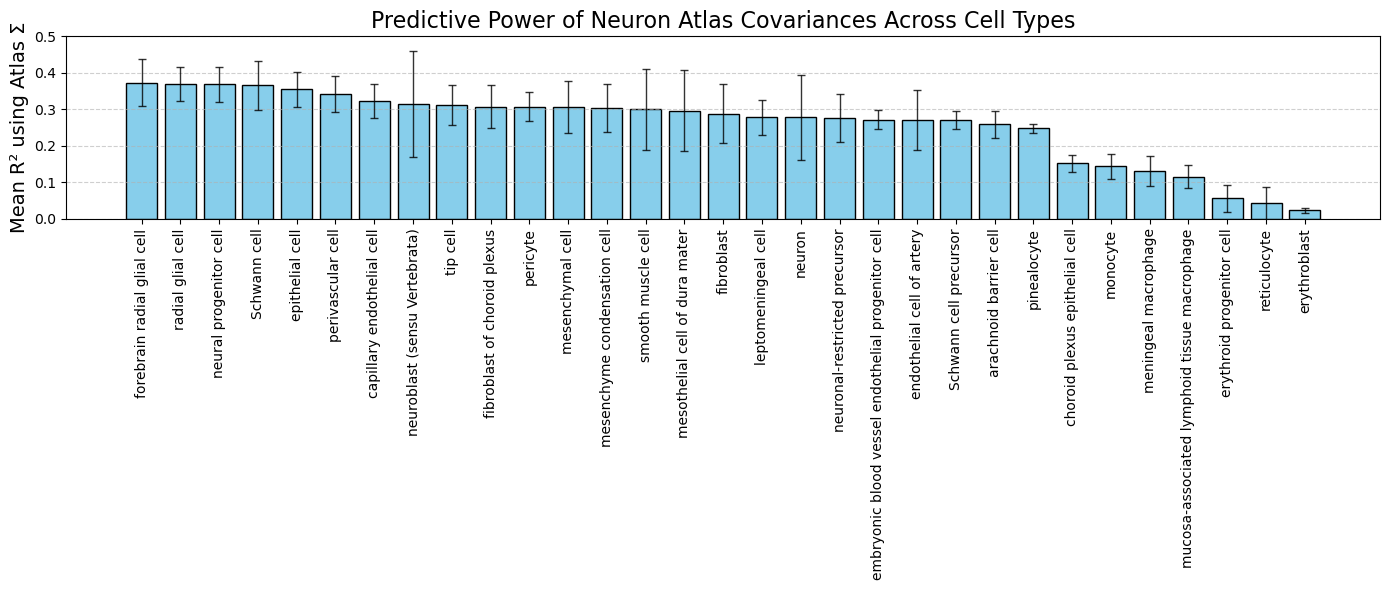

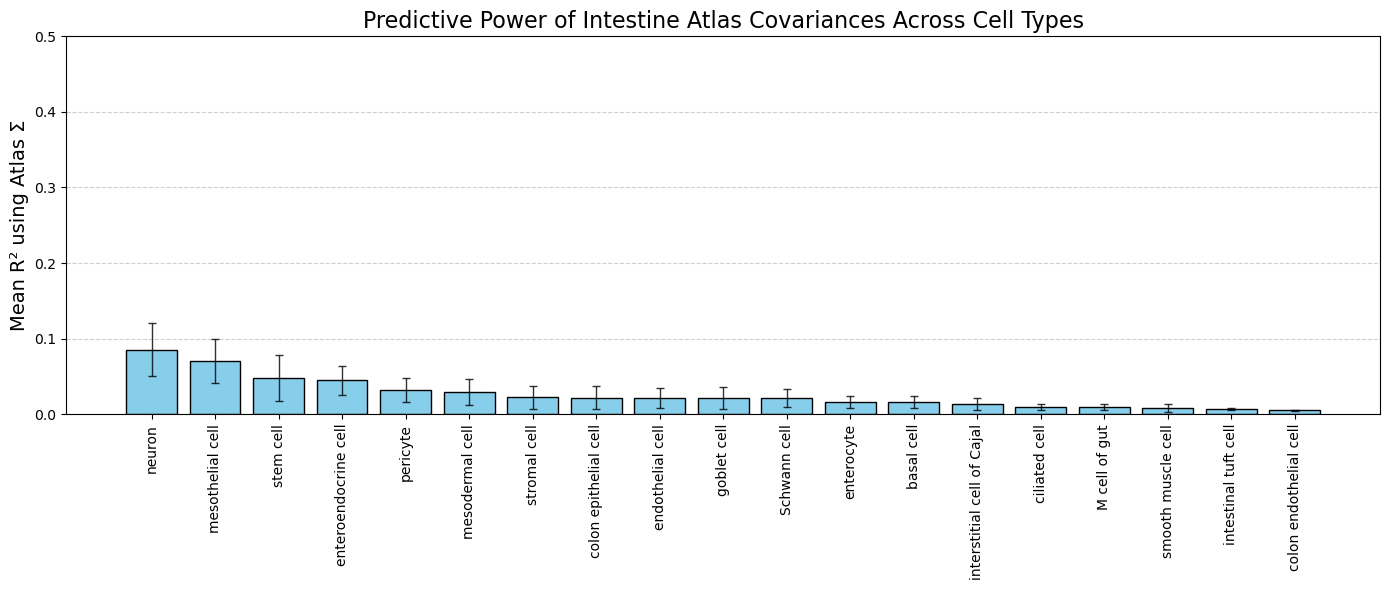

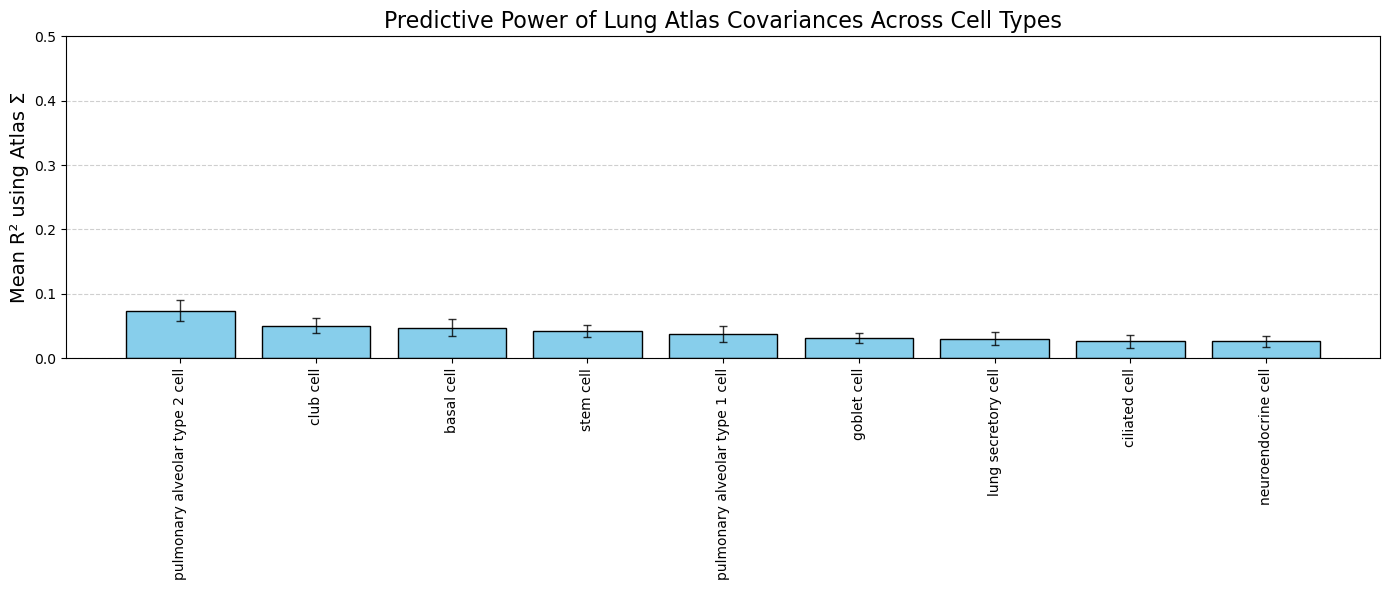

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# === Define utility function ===
def plot_r2_summary(csv_path, title, output_svg):
    # Load
    r2_summary_df = pd.read_csv(csv_path)

    # Group
    grouped = r2_summary_df.groupby("celltype")["mean_R2_atlas"]
    mean_r2 = grouped.mean()
    std_r2 = grouped.std()

    # Sort
    mean_r2_sorted = mean_r2.sort_values(ascending=False)
    std_r2_sorted = std_r2[mean_r2_sorted.index]

    # Plot
    plt.figure(figsize=(14, 6))
    plt.bar(mean_r2_sorted.index, mean_r2_sorted.values, yerr=std_r2_sorted.values,
            capsize=3, color="skyblue", edgecolor="k", error_kw={"elinewidth": 1, "alpha": 0.8})
    plt.ylabel("Mean R² using Atlas Σ", fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=90, ha='center')
    plt.ylim(0., 0.5)
    plt.tight_layout()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.savefig(output_svg)
    plt.show()

# === Plot each atlas ===
plot_r2_summary("neuron_atlas_celltype_r2_comparisons.csv",
                "Predictive Power of Neuron Atlas Covariances Across Cell Types",
                "mean_r2_neuron_atlas_by_celltype_with_errorbars.svg")

plot_r2_summary("intestine_atlas_celltype_r2_comparisons.csv",
                "Predictive Power of Intestine Atlas Covariances Across Cell Types",
                "mean_r2_intestine_atlas_by_celltype_with_errorbars.svg")

plot_r2_summary("lung_atlas_celltype_r2_comparisons.csv",
                "Predictive Power of Lung Atlas Covariances Across Cell Types",
                "mean_r2_lung_atlas_by_celltype_with_errorbars.svg")




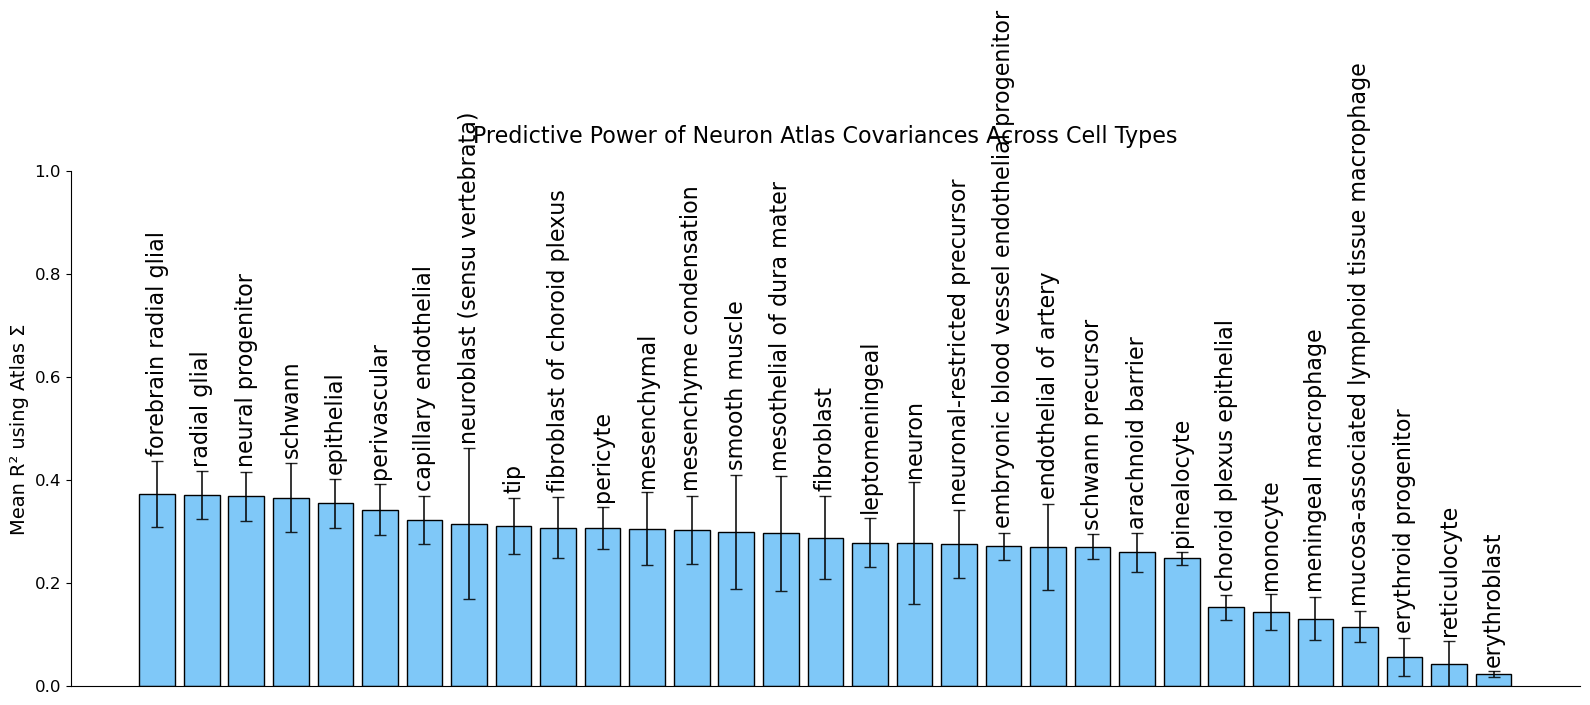

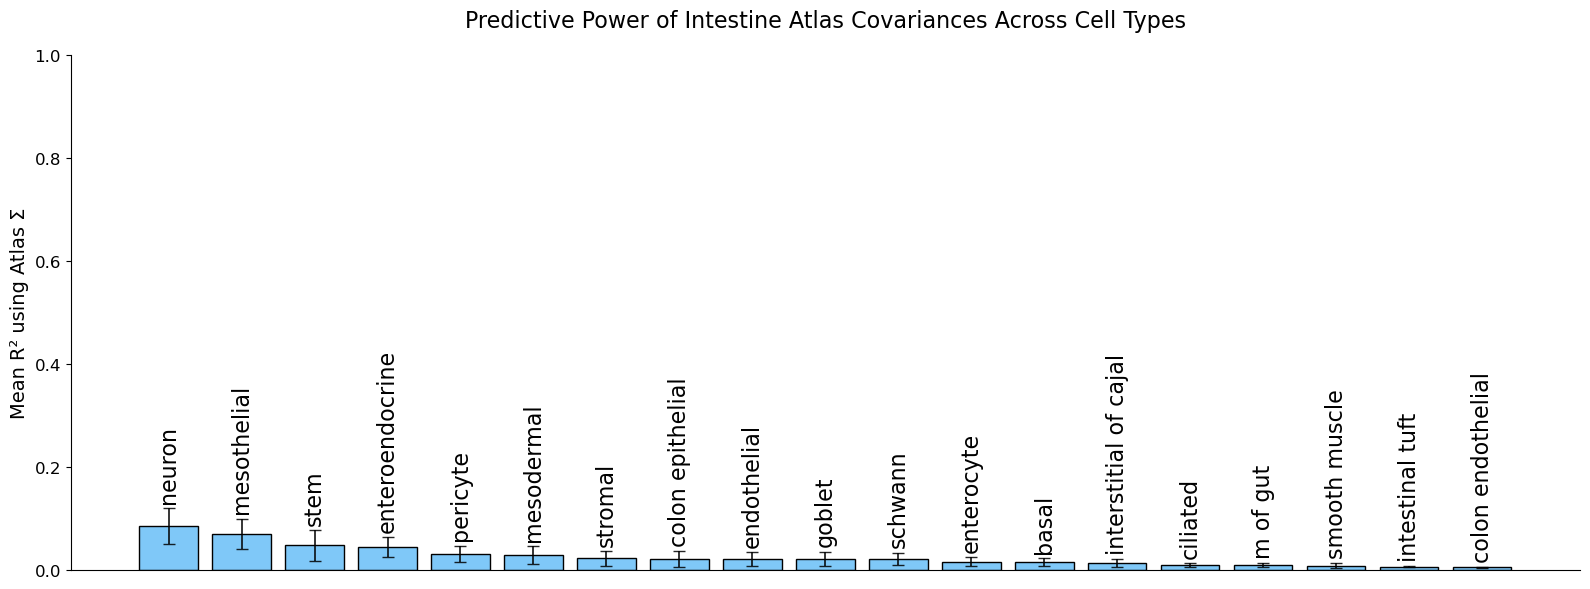

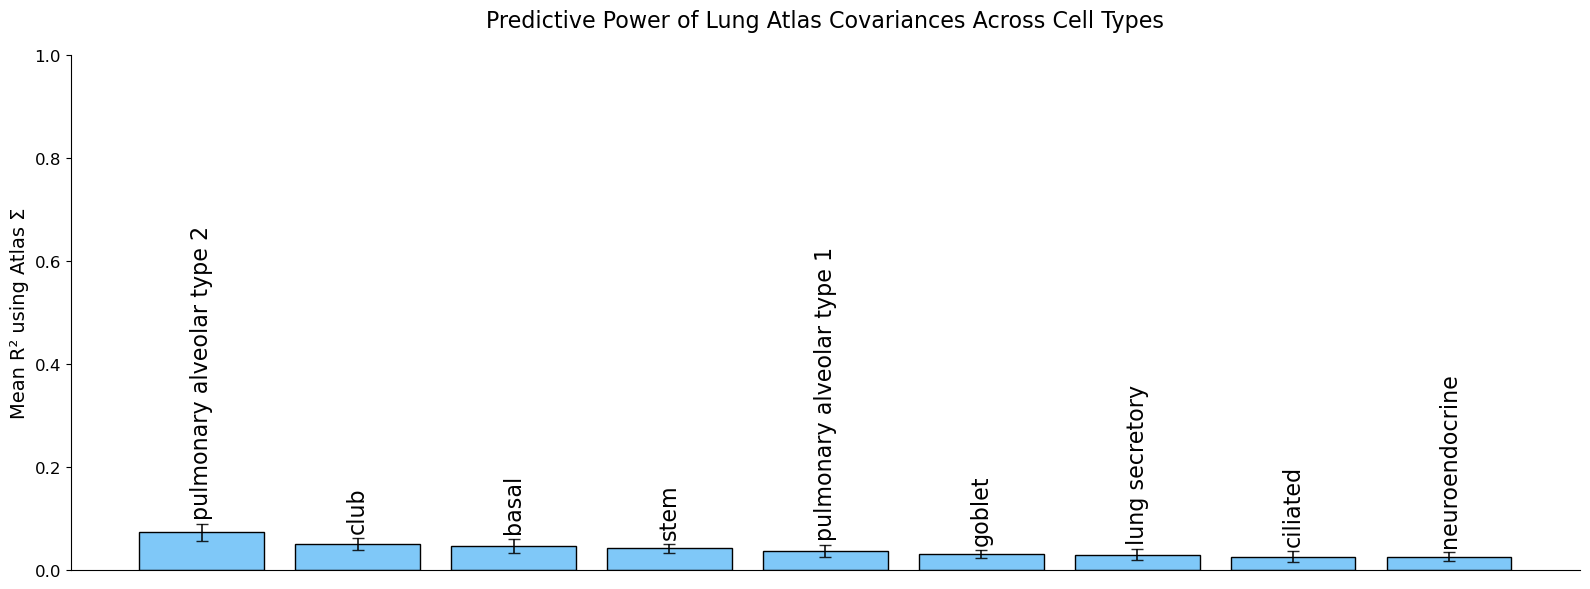

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def shorten_label(label):
    """
    Shorten long cell type names by removing 'cell' and collapsing whitespace.
    """
    label = label.lower()
    label = re.sub(r'\bcell\b', '', label)
    label = re.sub(r'\s+', ' ', label).strip()
    return label

def plot_r2_summary(csv_path, title, output_svg, title_offset=1.08):
    # Load and group
    df = pd.read_csv(csv_path)
    mean_r2 = df.groupby("celltype")["mean_R2_atlas"].mean()
    std_r2 = df.groupby("celltype")["mean_R2_atlas"].std()

    # Sort
    mean_r2 = mean_r2.sort_values(ascending=False)
    std_r2 = std_r2[mean_r2.index]
    short_labels = [shorten_label(lbl) for lbl in mean_r2.index]

    # Plot
    fig, ax = plt.subplots(figsize=(16, 6))
    x = range(len(mean_r2))
    bars = ax.bar(x, mean_r2.values,
                  yerr=std_r2.values,
                  capsize=4, color="#7fc8f8", edgecolor="k",
                  error_kw=dict(elinewidth=1.3, alpha=0.85))

    # Annotate above error bars
    for i, (label, mean, std) in enumerate(zip(short_labels, mean_r2.values, std_r2.values)):
        y = mean + std + 0.01
        ax.text(i, y, label, ha='center', va='bottom', rotation=90, fontsize=16)

    # Styling
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_ylabel("Mean R² using Atlas Σ", fontsize=14)
    ax.set_xticks([])
    ax.set_ylim(0, 1.)
    ax.spines[['top', 'right']].set_visible(False)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(False)

    # Move title upward
    plt.subplots_adjust(top=2.82)  # Decrease if you want *more* space below title
    plt.tight_layout()
    plt.savefig(output_svg, bbox_inches="tight")
    plt.show()

# === Run for each atlas ===
plot_r2_summary("neuron_atlas_celltype_r2_comparisons.csv",
                "Predictive Power of Neuron Atlas Covariances Across Cell Types",
                "mean_r2_neuron_atlas_by_celltype_with_errorbars.svg")

plot_r2_summary("intestine_atlas_celltype_r2_comparisons.csv",
                "Predictive Power of Intestine Atlas Covariances Across Cell Types",
                "mean_r2_intestine_atlas_by_celltype_with_errorbars.svg")

plot_r2_summary("lung_atlas_celltype_r2_comparisons.csv",
                "Predictive Power of Lung Atlas Covariances Across Cell Types",
                "mean_r2_lung_atlas_by_celltype_with_errorbars.svg")


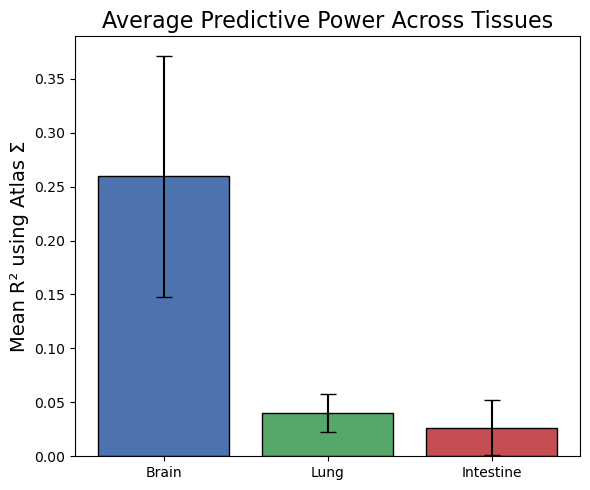

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load and aggregate R² from each atlas ===
def load_r2_summary(csv_path, label):
    df = pd.read_csv(csv_path)
    mean = df["mean_R2_atlas"].mean()
    std = df["mean_R2_atlas"].std()
    return {"tissue": label, "mean": mean, "std": std}

# === Collect statistics for each tissue ===
data = [
    load_r2_summary("neuron_atlas_celltype_r2_comparisons.csv", "Brain"),
    load_r2_summary("lung_atlas_celltype_r2_comparisons.csv", "Lung"),
    load_r2_summary("intestine_atlas_celltype_r2_comparisons.csv", "Intestine")
]

df_summary = pd.DataFrame(data)

# === Plot ===
plt.figure(figsize=(6, 5))
plt.bar(df_summary["tissue"], df_summary["mean"],
        yerr=df_summary["std"],
        capsize=6, color=["#4c72b0", "#55a868", "#c44e52"], edgecolor="k")

plt.ylabel("Mean R² using Atlas Σ", fontsize=14)
plt.title("Average Predictive Power Across Tissues", fontsize=16)
plt.tight_layout()
plt.savefig("mean_r2_by_tissue.svg")
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load each atlas R² summary ===
neuron_df = pd.read_csv("neuron_atlas_celltype_r2_comparisons.csv")
lung_df = pd.read_csv("lung_atlas_celltype_r2_comparisons.csv")
intestine_df = pd.read_csv("intestine_atlas_celltype_r2_comparisons.csv")

# === Compute average R² and standard deviation for each atlas ===
mean_r2s = {
    "Human Embryonic Meninges": neuron_df["mean_R2_atlas"].mean(),
    "Lung": lung_df["mean_R2_atlas"].mean(),
    "Intestine Organoid": intestine_df["mean_R2_atlas"].mean(),
}
std_r2s = {
    "Human Embryonic Meninges": neuron_df["mean_R2_atlas"].std(),
    "Lung": lung_df["mean_R2_atlas"].std(),
    "Intestine Organoid": intestine_df["mean_R2_atlas"].std(),
}

# === Plot ===
plt.figure(figsize=(8, 6))
labels = list(mean_r2s.keys())
means = list(mean_r2s.values())
errors = list(std_r2s.values())

plt.bar(labels, means, yerr=errors, capsize=6, color="mediumseagreen", edgecolor="k",
        error_kw={"elinewidth": 1.5, "alpha": 0.8})
plt.ylabel("Mean R² Across Cell Types", fontsize=14)
plt.title("Average Predictive Power Across Atlases", fontsize=16)
plt.ylim(0, 0.5)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.savefig("mean_r2_summary_by_atlas_with_errorbars.svg")
plt.show()


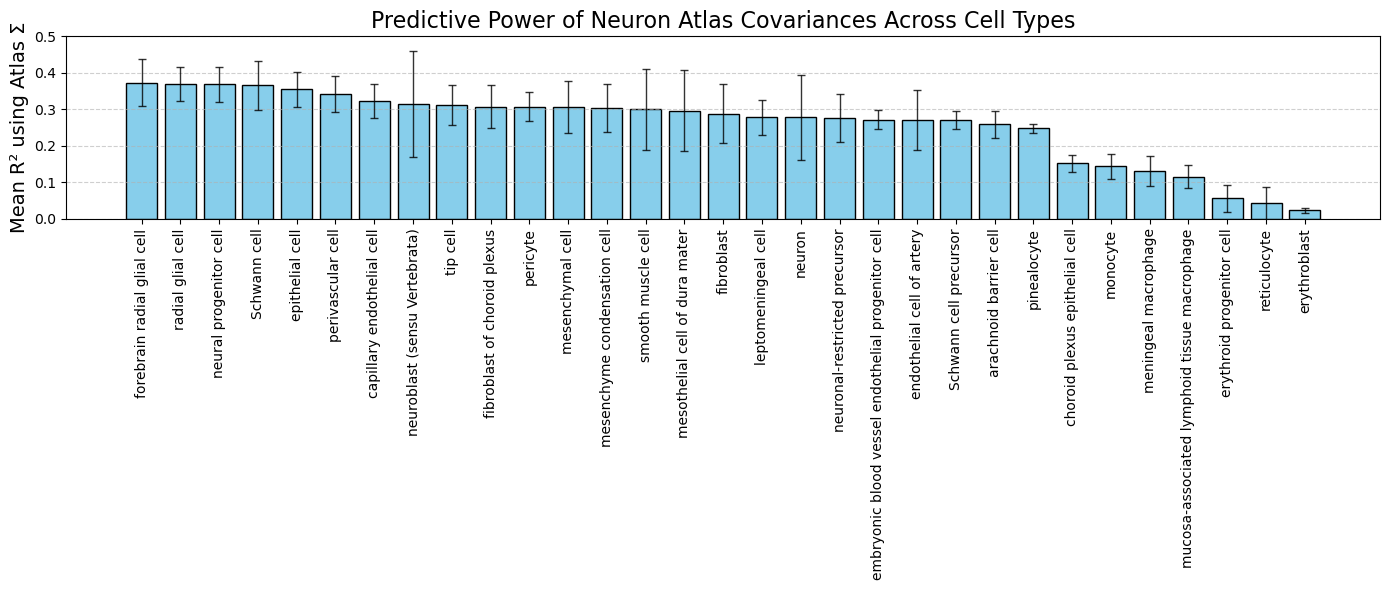

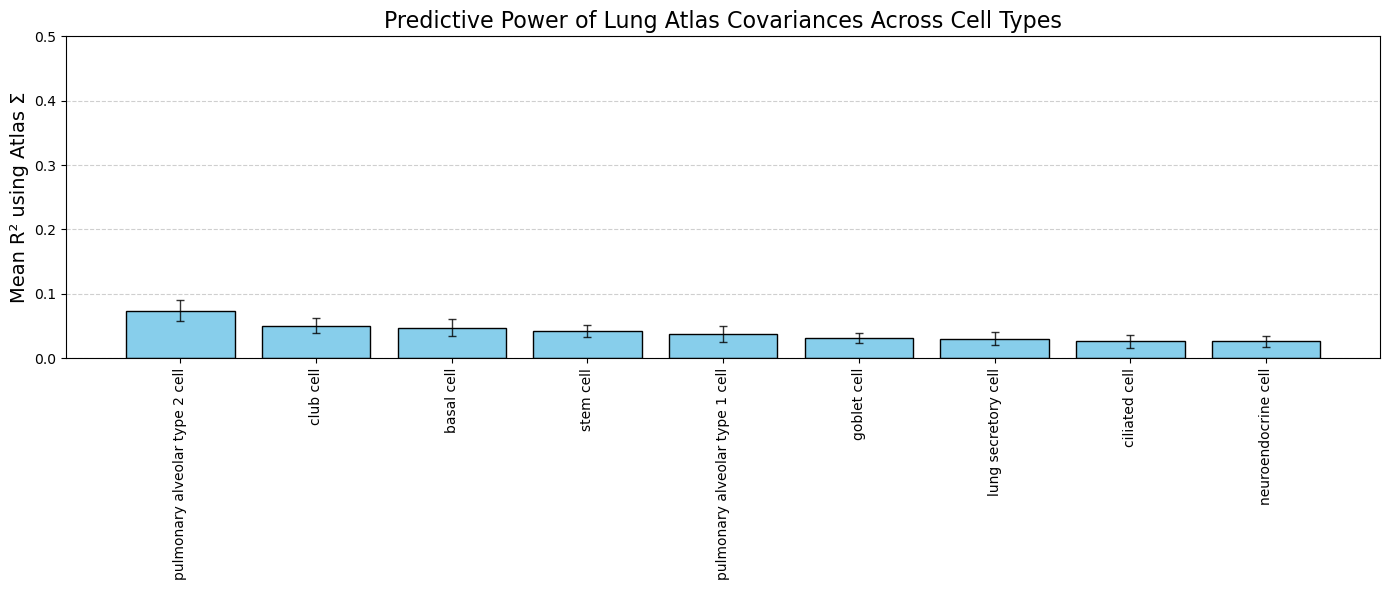

In [3]:
import pandas as pd
import matplotlib.pyplot as plt


import pandas as pd
import matplotlib.pyplot as plt

# === Load the summary if needed ===
r2_summary_df = pd.read_csv("neuron_atlas_celltype_r2_comparisons.csv")

# === Compute mean and std of R² from atlas Σ per celltype ===
grouped = r2_summary_df.groupby("celltype")["mean_R2_atlas"]
mean_r2 = grouped.mean()
std_r2 = grouped.std()

# === Sort by mean and align std accordingly ===
mean_r2_sorted = mean_r2.sort_values(ascending=False)
std_r2_sorted = std_r2[mean_r2_sorted.index]

# === Plot with error bars ===
plt.figure(figsize=(14, 6))
plt.bar(mean_r2_sorted.index, mean_r2_sorted.values, yerr=std_r2_sorted.values,
        capsize=3, color="skyblue", edgecolor="k", error_kw={"elinewidth": 1, "alpha": 0.8})

plt.ylabel("Mean R² using Atlas Σ", fontsize=14)
plt.title("Predictive Power of Neuron Atlas Covariances Across Cell Types", fontsize=16)
plt.xticks(rotation=90, ha='center')
plt.ylim(0.,0.5)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.savefig("mean_r2_atlas_by_celltype_with_errorbars.svg")
plt.show()





# === Load the summary if needed ===
r2_summary_df = pd.read_csv("lung_atlas_celltype_r2_comparisons.csv")

# === Compute mean and std of R² from atlas Σ per celltype ===
grouped = r2_summary_df.groupby("celltype")["mean_R2_atlas"]
mean_r2 = grouped.mean()
std_r2 = grouped.std()

# === Sort by mean and align std accordingly ===
mean_r2_sorted = mean_r2.sort_values(ascending=False)
std_r2_sorted = std_r2[mean_r2_sorted.index]

# === Plot with error bars ===
plt.figure(figsize=(14, 6))
plt.bar(mean_r2_sorted.index, mean_r2_sorted.values, yerr=std_r2_sorted.values,
        capsize=3, color="skyblue", edgecolor="k", error_kw={"elinewidth": 1, "alpha": 0.8})

plt.ylabel("Mean R² using Atlas Σ", fontsize=14)
plt.title("Predictive Power of Lung Atlas Covariances Across Cell Types", fontsize=16)
plt.xticks(rotation=90, ha='center')
plt.ylim(0.,0.5)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.savefig("mean_r2_lung_atlas_by_celltype_with_errorbars.svg")
plt.show()





In [36]:
neuron_atlas_path = "lung_atlas.h5ad"

# === Load neuron atlas and determine reference size ===
print("📥 Loading lung atlas...")
adata_atlas_full = ad.read_h5ad(neuron_atlas_path)

📥 Loading lung atlas...


In [37]:
# === Print dataset dimensions ===
print(f"adata shape: {adata_atlas_full.shape} (cells x genes)\n")

# === View observation (cell-level) metadata ===
print("Available `obs` columns (cell metadata):")
print(adata_atlas_full.obs.columns.tolist(), "\n")

# === View variable (gene-level) metadata ===
print("Available `var` columns (gene metadata):")
print(adata_atlas_full.var.columns.tolist(), "\n")



# Optional: print unique perturbations or cell types
if "perturbation" in adata_atlas_full.obs:
    print("\nUnique perturbations:")
    print(adata_atlas_full.obs["perturbation"].unique())

if "cell_type" in adata_atlas_full.obs:
    print("\nUnique cell types:")
    print(adata_atlas_full.obs["cell_type"].unique())


adata shape: (221425, 25521) (cells x genes)

Available `obs` columns (cell metadata):
['sample_id', 'publication', 'sample_name', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'batch', 'derive', 'time', 'protocol', 'molecular', 'gel', 'level_1', 'level_2', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'is_primary_data', 'tissue_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'] 

Available `var` columns (gene metadata):
['feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'] 


Unique cell types:
['basal cell', 'club cell', 'ciliated cell', 'pulmonary alveolar type 1 cell', 'pul